# High resolution imaging: 2MASS, PanSTARRS, K2

This notebook makes little postage stamps for evaluating contamination from stars, etc.

In [1]:
import lightkurve

In [2]:
# %load /Users/obsidian/Desktop/defaults.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
from astropy.nddata import Cutout2D
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.visualization import (PercentileInterval, SqrtStretch,
                                   ImageNormalize)
from astropy.io import fits
from astropy.wcs import WCS
import montage_wrapper as montage

In [4]:
from reproject import reproject_interp, reproject_exact

In [5]:
pos = SkyCoord(ra='08 51 13.354', dec='+11 51 40.15', unit=(u.hourangle, u.deg), frame='icrs')

### What high resolution imaging do we want?

| source | band | filename |
| -- | -- | -- |
| 2MASS | J | `data/imaging/2MASS/qJ_asky_971116n1210266.fits`|
| 2MASS | H | `data/imaging/2MASS/qH_asky_971116n1210266.fits`|
| 2MASS | K | `data/imaging/2MASS/qK_asky_971116n1210266.fits`|
| PanSTARRS | g | `data/imaging/PanSTARRS/MAST_2019-01-23T1325/PS1/rings.v3.skycell.1534.096.stk.g/rings.v3.skycell.1534.096.stk.g.unconv.fits`|

### K2 Campaigns 5 and 16

Let's use the FFIs for simplicity-- the TPFs cut off the star sometimes.

In [6]:
tpf05 = lightkurve.KeplerTargetPixelFile('/Users/obsidian/.lightkurve-cache/mastDownload/K2/ktwo200008674-c05_lc/ktwo200008674-c05_lpd-targ.fits.gz')
tpf05.module, tpf05.output

(6, 1)

In [7]:
tpf16 = lightkurve.KeplerTargetPixelFile('/Users/obsidian/.lightkurve-cache/mastDownload/K2/ktwo200200534-c16_lc/ktwo200200534-c16_lpd-targ.fits.gz')
tpf16.module, tpf16.output

(15, 4)

In [8]:
hdus_c5 = fits.open('/Volumes/Truro/ffi/ktwo2015127093352-c05_ffi-cal.fits')
hdu_c5_raw = hdus_c5['MOD.OUT 6.1']

In [9]:
hdus_c16 = fits.open('/Volumes/Truro/ffi/ktwo2018030100110-c16_ffi-cal.fits')
hdu_c16_raw = hdus_c16['MOD.OUT 15.4']

### PanSTARRS

In [12]:
hdus_PSg = fits.open('../data/imaging/PanSTARRS/MAST_2019-01-23T1325/PS1/rings.v3.skycell.1534.096.stk.g/rings.v3.skycell.1534.096.stk.g.unconv.fits')

In [13]:
hdus_PSg.info()

Filename: ../data/imaging/PanSTARRS/MAST_2019-01-23T1325/PS1/rings.v3.skycell.1534.096.stk.g/rings.v3.skycell.1534.096.stk.g.unconv.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1                1 CompImageHDU    199   (6248, 6250)   int16   


In [14]:
%%capture
hdus_PSg_raw = hdus_PSg[1]
wcs_PSg = WCS(hdus_PSg_raw.header)

In [15]:
norm = ImageNormalize(hdus_PSg_raw.data, interval=PercentileInterval(99))

In [16]:
size = (60*u.arcsecond, 60*u.arcsecond)
cutout = Cutout2D(hdus_PSg_raw.data, pos, size, wcs=wcs_PSg)

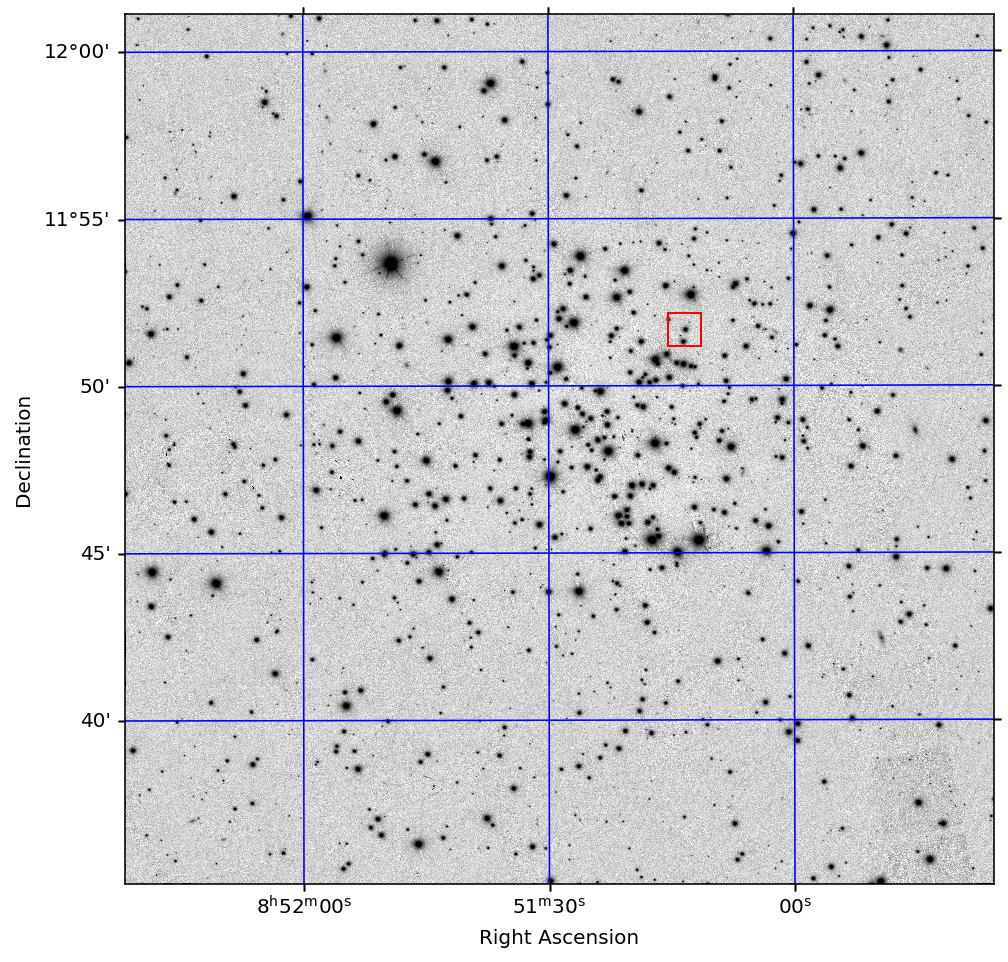

In [17]:
plt.figure(figsize=(8,8))
ax1 = plt.subplot(1,1,1, projection=wcs_PSg)
ax1.imshow(hdus_PSg_raw.data, origin='lower', norm=norm, cmap=plt.cm.gray_r)
ax1.coords.grid(color='blue')

cutout.plot_on_original(color='red')

ax1.coords['ra'].set_axislabel('Right Ascension')
ax1.coords['dec'].set_axislabel('Declination')
#ax1.set_title('Reprojected K2 C5')

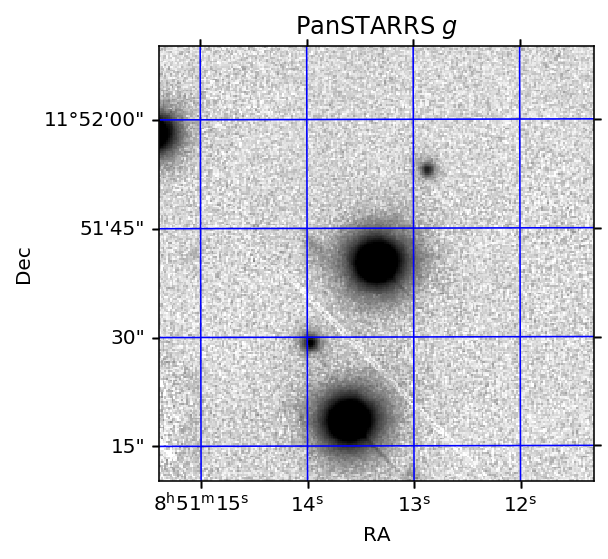

In [18]:
norm = ImageNormalize(cutout.data, interval=PercentileInterval(97))

ax = plt.gca(projection=cutout.wcs)
ax.imshow(cutout.data, norm=norm, cmap=plt.cm.gray_r)
ax.set(xlabel="RA", ylabel="Dec")
ax.coords.grid(color='blue')
plt.title('PanSTARRS $g$');

### 2MASS

In [19]:
! ls ../data/imaging/2MASS/

qH_asky_971116n1210266.fits qK_asky_971116n1210266.fits
qJ_asky_971116n1210266.fits


In [20]:
hdus_2MJ = fits.open('../data/imaging/2MASS/qJ_asky_971116n1210266.fits')

In [21]:
hdus_2MJ.info()

Filename: ../data/imaging/2MASS/qJ_asky_971116n1210266.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     114   (62, 61)   int16   


In [22]:
%%capture
hdus_2MJ_raw = hdus_2MJ[0]
wcs_2MJ = WCS(hdus_2MJ_raw.header)

In [23]:
size = (60*u.arcsecond, 60*u.arcsecond)
cutout = Cutout2D(hdus_2MJ_raw.data, pos, size, wcs=wcs_2MJ)
cutout_2M = Cutout2D(hdus_2MJ_raw.data, pos, size, wcs=wcs_2MJ)

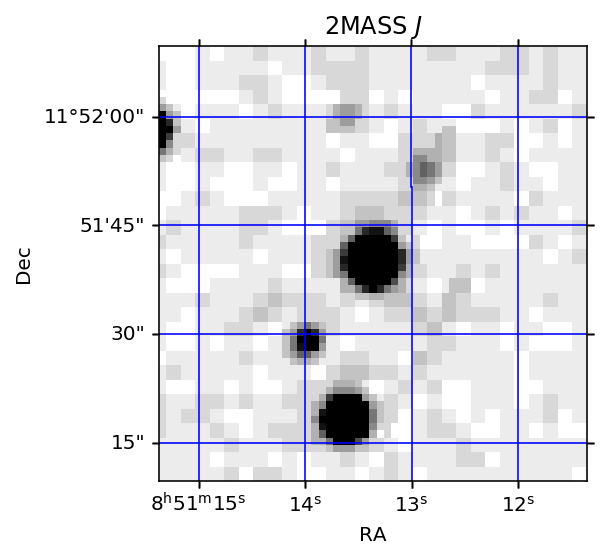

In [24]:
norm = ImageNormalize(cutout.data, interval=PercentileInterval(95))

ax = plt.gca(projection=cutout.wcs)
ax.imshow(cutout.data, norm=norm, cmap=plt.cm.gray_r)
ax.set(xlabel="RA", ylabel="Dec")
ax.coords.grid(color='blue')
plt.title('2MASS $J$');

### K2 Campaign 5

Now rotate the HDU to have North up:

In [25]:
wcs_c16 = WCS(hdu_c16_raw.header)
wcs_c5 = WCS(hdu_c5_raw.header)

In [26]:
size = (60*u.arcsecond, 60*u.arcsecond)
cutout = Cutout2D(hdu_c16_raw.data, pos, size, wcs=wcs_c16)

In [30]:
array, footprint = reproject_interp(hdu_c5_raw, hdus_2MJ_raw.header)#, order='nearest-neighbor')

In [31]:
array, footprint = reproject_interp(hdu_c5_raw, cutout.wcs, cutout.shape)#, order='nearest-neighbor')

Reprojected

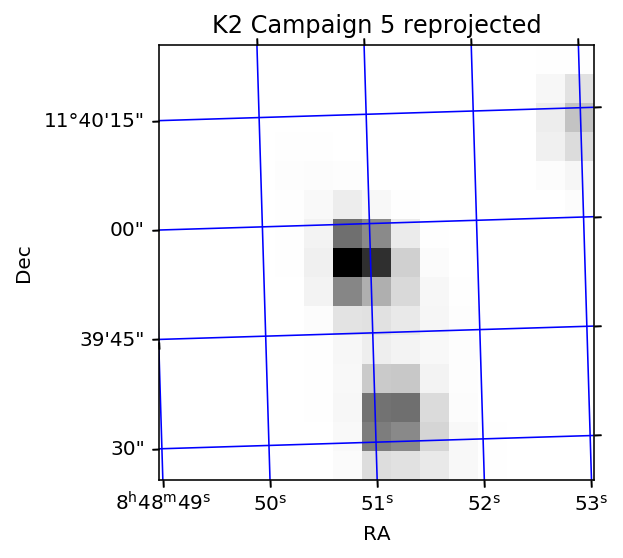

In [32]:
norm = ImageNormalize(array, interval=PercentileInterval(95))

ax = plt.gca(projection=wcs_c16)
ax.imshow(array, cmap=plt.cm.gray_r)
ax.set(xlabel="RA", ylabel="Dec")
ax.coords.grid(color='blue')
plt.title('K2 Campaign 5 reprojected');

### K2 Campaign 16

In [33]:
size = (60*u.arcsecond, 60*u.arcsecond)
cutout = Cutout2D(hdu_c16_raw.data, pos, size, wcs=wcs_c16)

In [34]:
#array, footprint = reproject_interp((cutout.data, cutout.wcs), hdus_2MJ_raw.header, order='nearest-neighbor')

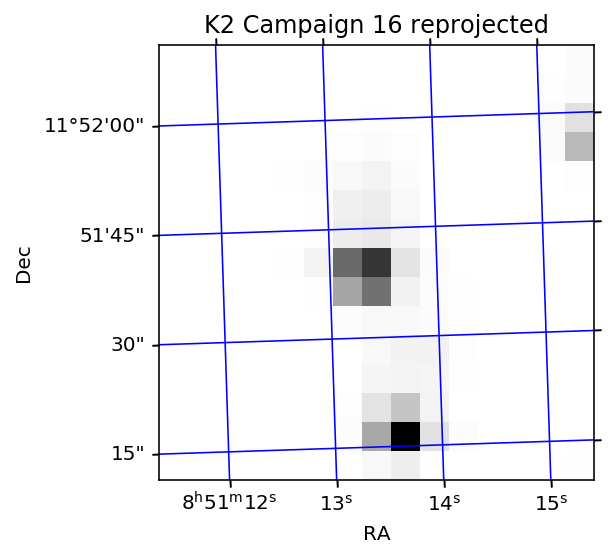

In [35]:
norm = ImageNormalize(array, interval=PercentileInterval(95))

ax = plt.gca(projection=cutout.wcs)
ax.imshow(cutout.data, cmap=plt.cm.gray_r)
ax.set(xlabel="RA", ylabel="Dec")
ax.coords.grid(color='blue')
plt.title('K2 Campaign 16 reprojected');

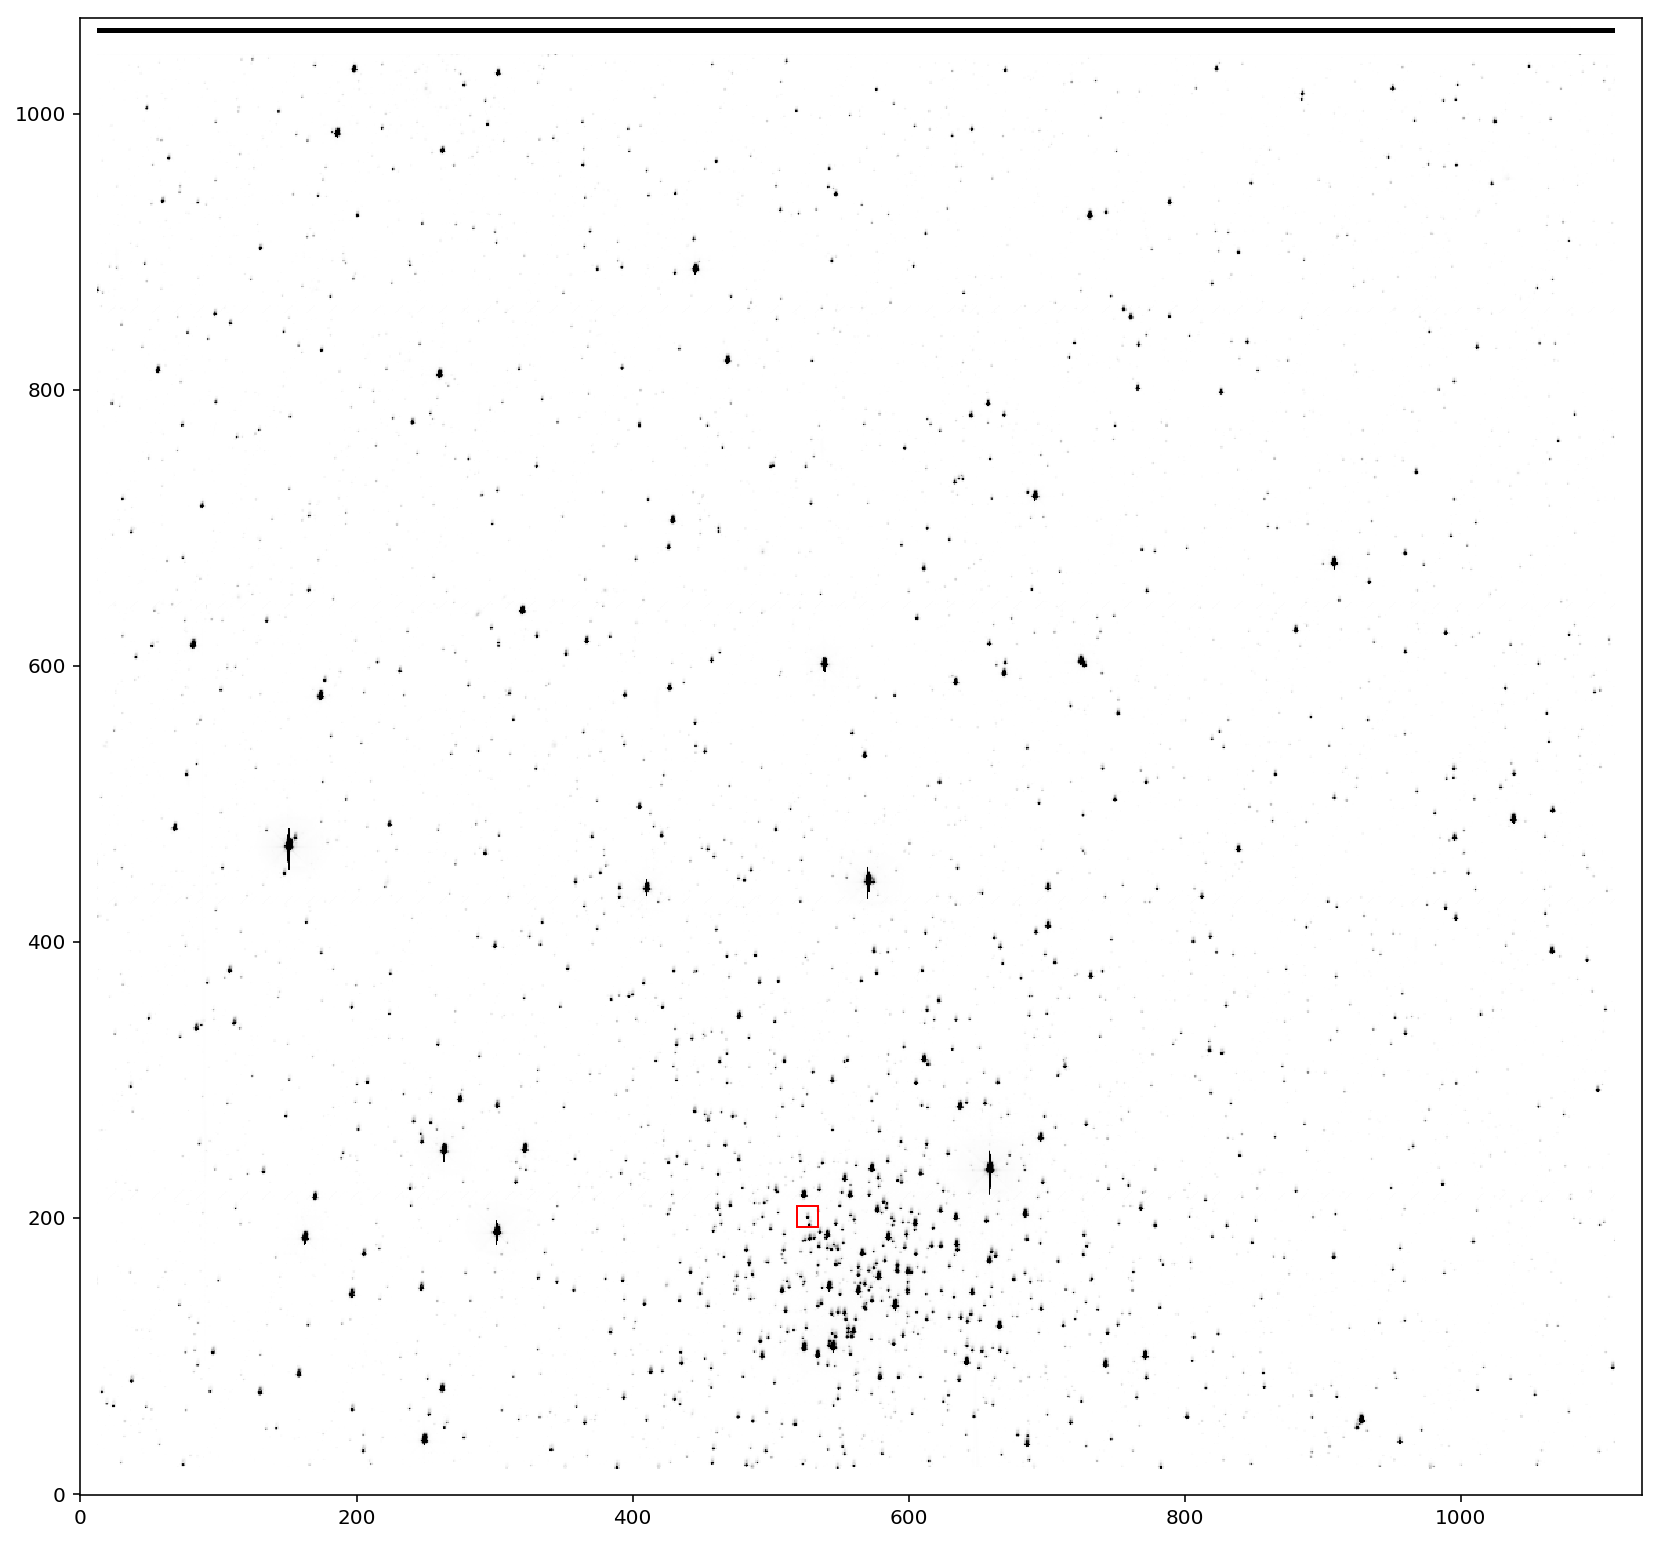

In [126]:
plt.figure(figsize=(14,14))
plt.imshow(hdu_c16_raw.data, origin='lower', norm=norm, cmap=plt.cm.gray_r)
cutout.plot_on_original(color='red')

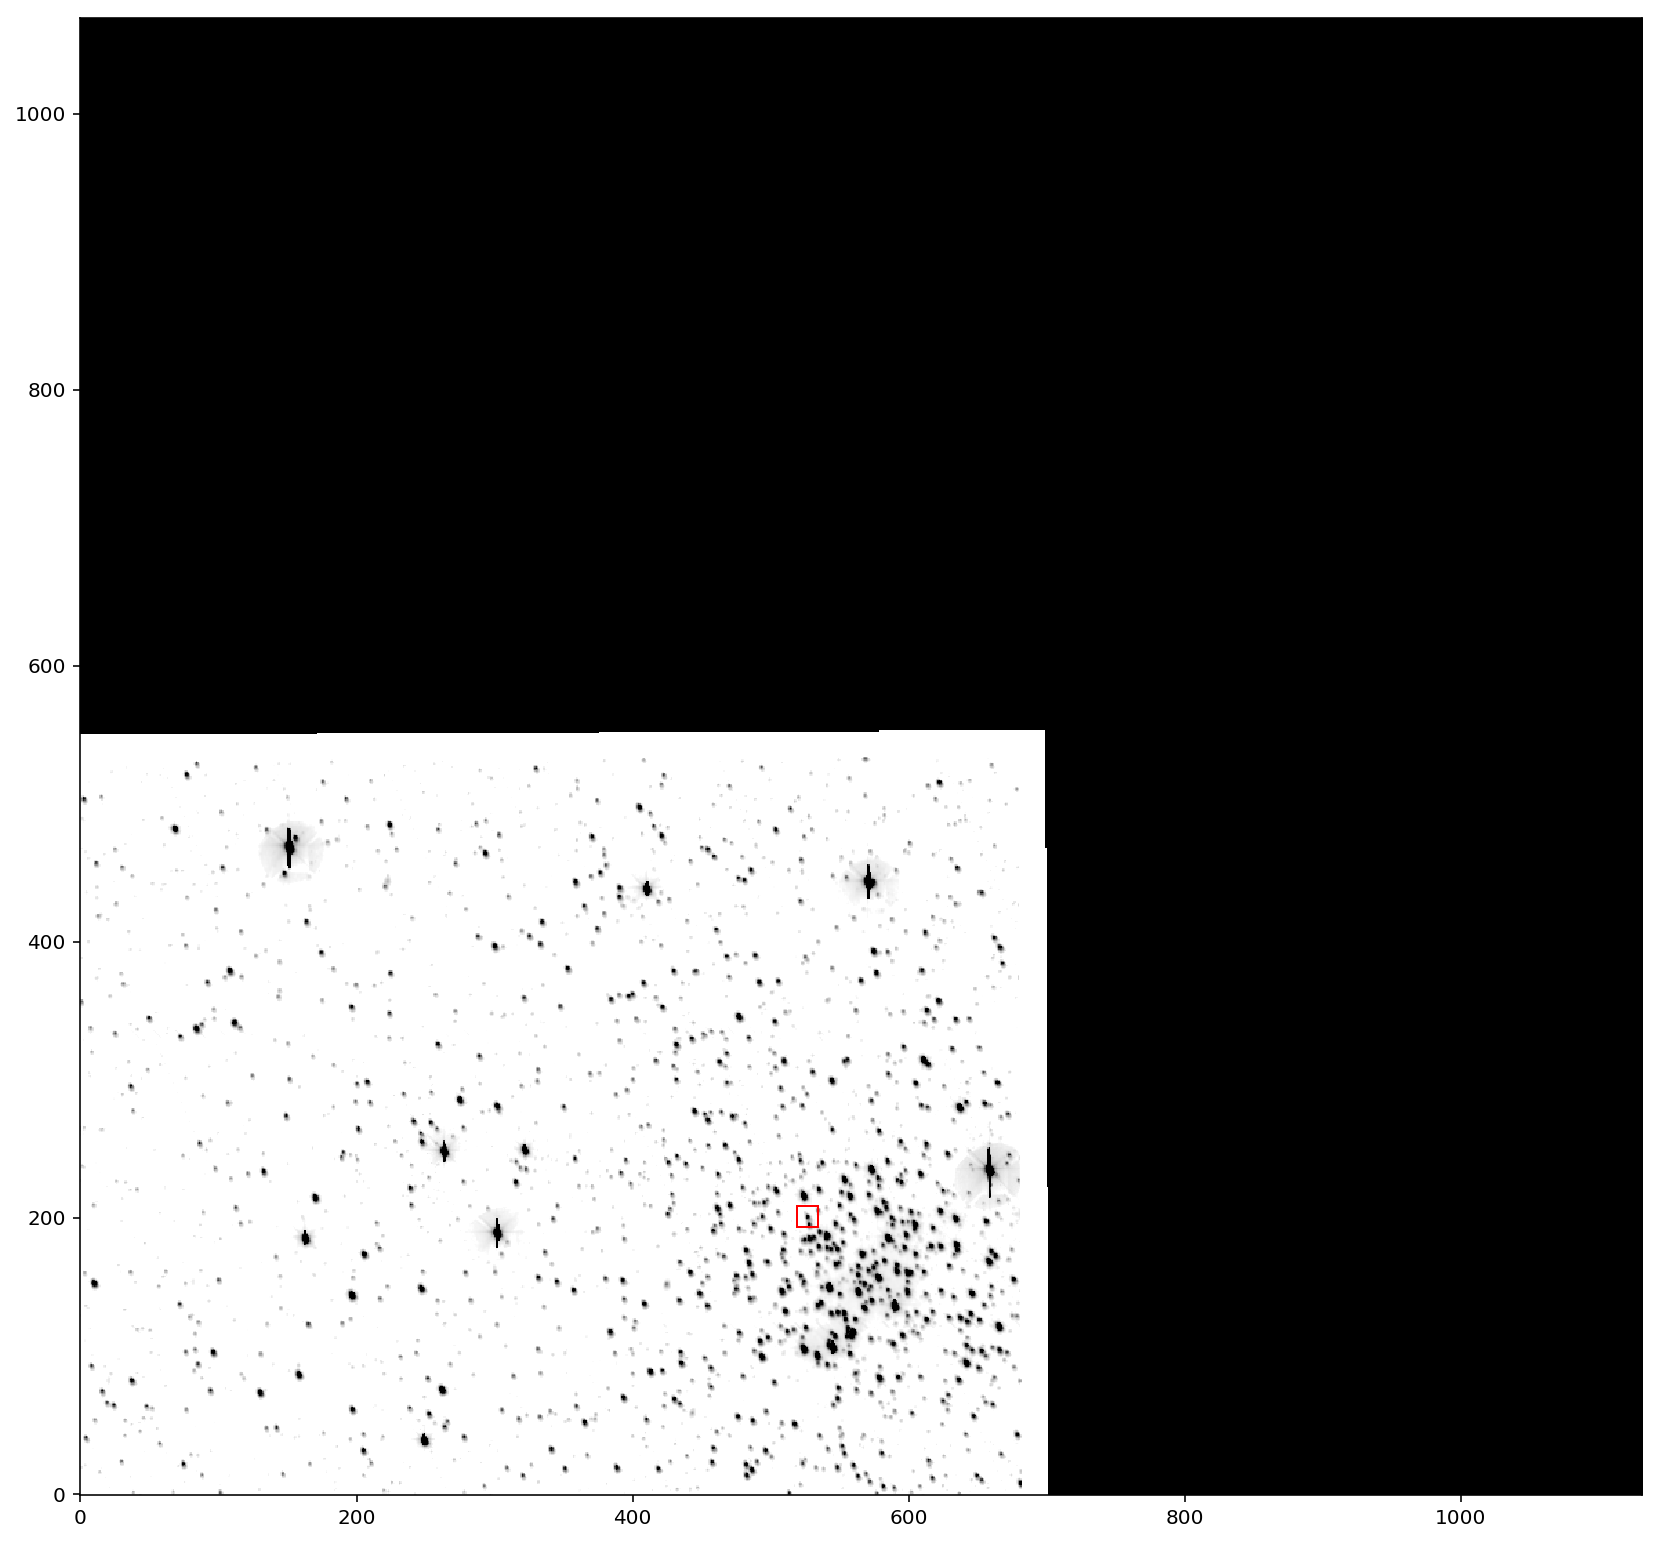

In [21]:
plt.figure(figsize=(14,14))
plt.imshow(array, origin='lower', norm=norm, cmap=plt.cm.gray_r)
cutout.plot_on_original(color='red')

### PanSTARRS

In [22]:
import os, warnings
from astropy.io import fits
from astropy.table import Table
import pylab

In [23]:
def getimages(ra,dec,size=240,filters="griz",auxiliary="data,mask"):
    
    """Query hlspfilenames.py service to get a list of images
    
    ra, dec = position in degrees
    size = image size in pixels (0.25 arcsec/pixel)
    Returns a table with the results
    """
    
    service = "https://ps1images.stsci.edu/cgi-bin/hlspfilenames.py"
    url = ("{service}?ra={ra}&dec={dec}&size={size}&format=fits"
           "&auxiliary={auxiliary}&filters={filters}").format(**locals())
    table = Table.read(url, format='ascii')
    return table

def groupimages(table):
    
    """Group images by filter and image type
    
    Returns a nested dictionary:
    d[filter] = {'warp': rowlist, 'warp.mask': rowlist}
    where the row lists are sorted by mjd
    """
    
    d = {}
    for row in table:
        filter = row['filter']
        dsub = d.setdefault(filter,{})
        dsub.setdefault(row['type'],[]).append((row['mjd'], row))
    # sort row lists by MJD and strip off the mjd value
    for filter, entry in d.items():
        for filetype, flist in entry.items():
            flist.sort()
            entry[filetype] = [x[1] for x in flist]            
    return d

In [24]:
ra0 = pos.ra.value
dec0 = pos.dec.value
table = getimages(ra0,dec0,size=320*2)
print('Found', len(table), 'images')
print('Columns:', table.colnames)
groups = groupimages(table)
print(len(groups),'filters')
for filter, entry in groups.items():
    for filetype, flist in entry.items():
        print(filter,filetype,len(flist))

Found 96 images
Columns: ['projcell', 'subcell', 'ra', 'dec', 'filter', 'mjd', 'type', 'filename', 'url']
4 filters
r warp 10
r warp.mask 10
g warp 21
g warp.mask 21
i warp.mask 13
i warp 13
z warp 4
z warp.mask 4


In [25]:
def stackimages(imagelist, masklist):
    """Read FITS images from URLs and stack them
    
    imagelist is list of rows (from getimages) for the data
    masklist is corresponding list of rows for the stacks
    Returns stacked image, count of exposures in stack
    """
    n = len(imagelist)
    if n != len(masklist):
        raise ValueError("Mis-match in imagelist and masklist")
    if n == 0:
        raise ValueError("imagelist is empty")
    # assume all images are the same size
    im0 = fits.open(imagelist[0])[0].data
    mask0 = fits.open(masklist[0])[0].data
    # mask ought to be int but is float for some reason
    mask0[np.isnan(mask0)] = 0
    mask0 = mask0.astype(np.int32)
    imstack = np.zeros((n,im0.shape[0],im0.shape[1]), dtype=im0.dtype)
    imstack[0] = im0
    maskstack = np.zeros((n,im0.shape[0],im0.shape[1]), dtype=mask0.dtype)
    maskstack[0] = mask0
    for i in range(1,n):
        imstack[i] = fits.open(imagelist[i])[0].data
        mask0 = fits.open(masklist[i])[0].data
        mask0[np.isnan(mask0)] = 0
        maskstack[i] = mask0.astype(np.int32)
    # ignore all non-zero mask values in stack (conservative)
    imstack[maskstack != 0] = np.nan
    # suppress the annoying nanmean warning where all pixels are blank
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        im = np.nanmean(imstack,axis=0)
    count = np.isfinite(imstack).sum(axis=0)
    return im, count

filter = 'i'
fdict = groups[filter]
imagelist = [x['url'] for x in fdict['warp']]
masklist = [x['url'] for x in fdict['warp.mask']]
im, count = stackimages(imagelist, masklist)

In [26]:
im0 = fits.open(imagelist[0])[0]

In [27]:
wcs_PS = WCS(im0.header)

this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]


In [28]:
im[im!=im] = 0

In [35]:
(array == array).sum()

0

In [29]:
array, footprint = reproject_exact((im, wcs_PS), hdu_c16_raw.header)

/Users/obsidian/anaconda3/envs/subsub/lib/python3.6/site-packages/reproject/spherical_intersect/core.py:180: RuntimeWarning: divide by zero encountered in true_divide
  array_new /= weights


In [31]:
size = (60*u.arcsecond, 60*u.arcsecond)
cutout = Cutout2D(array, pos, size, wcs=wcs_c16)

norm = ImageNormalize(cutout.data, interval=PercentileInterval(95),
                      stretch=SqrtStretch())

ax = plt.gca(projection=cutout.wcs)
ax.imshow(cutout.data, norm=norm, cmap=plt.cm.gray_r)
ax.set(xlabel="RA", ylabel="Dec")
ax.coords.grid(color='blue')
plt.title('K2 Campaign 16: Pan-STARRS $i$');

/Users/obsidian/anaconda3/envs/subsub/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1259: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


TypeError: 'numpy.float64' object is not iterable